In [1]:
import os
import glob
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
import pandas as pd

In [2]:
def parse_filename(name):
#     221021 data: 'A1-pGP-625.27-EGFP-00.tif'
    name_split = name.split('-')
#     return [name_split[0], name_split[1], name_split[2], fluor] ## 210409 data
    return name_split[0],name_split[2],name_split[-2],name_split[-1].split('.')[0] ## 210916 data: well,construct,fluor,img_no.

In [3]:
date = '20221021_S2confocal_raw'
plate = 'P1'
imgPath = os.path.join(r'Z:\GECIScreenData\GECI_Imaging_Data\Non-production',date,plate)
sumPath = os.path.join(r'Y:\S2_cell_sensor_expression',date,plate)
savePath = r'Z:\Presentations\Jihong\GENIE production\221206\S1_confocal'
if not os.path.exists(savePath):
    os.makedirs(savePath)
os.path.exists(imgPath)

True

no. of rois:  5184


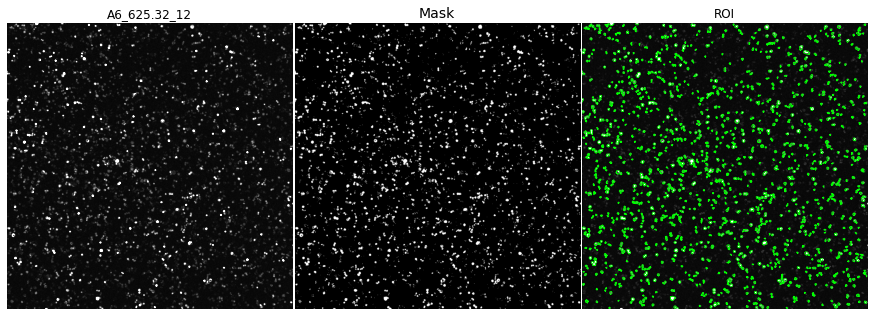

In [4]:
all_tif_files = os.listdir(imgPath)
all_tif_files = [f for f in all_tif_files if ('.tif' in f)]
all_tdt_files = [f for f in all_tif_files if ('tdTom' in f)]
all_gfp_files = [f for f in all_tif_files if ('EGFP' in f)]

Date = []
Plate = []
Well = []
Construct = []
Pixels_tdt = []
Pixels_gfp = []
Pixels_ratio = []

thre = 20
W = np.zeros([1048576,2])
for i in range(1024):
    W[i*1024:(i+1)*1024,0] = np.ones(1024)*i
    W[i*1024:(i+1)*1024,1] = np.arange(1024)
W = np.array(W)
    
for tdt_img in all_tdt_files:
    
    tdt_img_array = imread(imgPath + '/' + tdt_img)
    gfp_img_array = imread(imgPath + '/' + tdt_img.replace('tdTom','EGFP'))

    tdt_img_mean = tdt_img_array
    gfp_img_mean = gfp_img_array
    
    Fb = np.min(gfp_img_mean)
    mask = tdt_img_mean>Fb+2000
    contours = measure.find_contours(mask,fully_connected = 'high')
    
    well,construct,fluor,img_no = parse_filename(tdt_img)

    plt.figure(figsize=[12,5])
    ax1 = plt.subplot(1,3,1)
    ax1.imshow(tdt_img_mean,cmap='gray',vmax=Fb+np.max(tdt_img_mean)/8)
    ax1.set_title('%s_%s_%s' %(well,construct,img_no))
    ax1.axis('off')
    
    rois = []
    print('no. of rois: ', len(contours))
    ax2 = plt.subplot(1,3,2)
    ax2.imshow(mask,cmap='gray')
    ax2.axis('off')
    ax2.set_title('Mask',size=14)
    
    ax3 = plt.subplot(1,3,3)
    ax3.imshow(tdt_img_mean,cmap='gray',vmax=Fb+np.max(tdt_img_mean)/8)
    ax3.axis('off')
    
    c = 0

    for contour in contours:
        if contour.shape[0]>thre:
           
            ax3.plot(contour[:,1],contour[:,0],color = 'lime',lw=0.75)

            p = Path(contour)
            roi = p.contains_points(W)
            roi = roi.reshape(1024,1024)
            rois.append(roi)
            
            pixels_tdt = np.sum(roi*tdt_img_mean)/np.sum(roi)
            pixels_gfp = np.sum(roi*gfp_img_mean)/np.sum(roi)
            pixels_ratio = pixels_gfp / pixels_tdt
            
            Date.append(date)
            Plate.append(plate)
            Well.append(well)
            Construct.append(construct)
            Pixels_tdt.append(pixels_tdt)
            Pixels_gfp.append(pixels_gfp)
            Pixels_ratio.append(pixels_ratio)
            
#             c+=1
#             if c>100:
#                 break

    ax3.set_title('ROI')
            
    plt.tight_layout(pad=0.2)
#     plt.savefig(savePath+'\\00_example_%s_%s_%s.svg' %(well,construct,img_no),format='svg')
    plt.show()
    break

In [5]:
df = pd.DataFrame()

In [6]:
df['Date'] = Date
df['Plate'] = Plate
df['Well'] = Well
df['Construct'] = Construct
df['Pixels_tdt'] = Pixels_tdt
df['Pixels_gfp'] = Pixels_gfp
df['Pixels_ratio'] = Pixels_ratio

In [7]:
# df
df.to_pickle(sumPath+'\\%s.pkl' %date)

In [8]:
sumPath

'Y:\\S2_cell_sensor_expression\\20221021_S2confocal_raw\\P1'